## Deep Transfer Learning with INCEPTION Network on DNA Sequence Dataset

By: Sk. Tanzir Mehedi

Importing libraries

In [ ]:
import time
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import TensorBoard
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

Importing the Dataset

In [ ]:
dataset=pd.read_csv('preprocessedDNASequenceDatase.csv')

Exploratory Data Analysis

In [ ]:
dataset.head()

,page_like,page_followers,page_category,familiar,symbol,age,sex,post_category,post_views,post_share,post_comments,post_comment_type,post_like,post_love,post_smile,post_care,post_wow,post_angry,post_sad,label
0,0.604743,0.62549,0,1,0.583333,0.0,1.0,0.004926,0.000009,4.900000e-07,0.000008,0.333333,0.000025,6.120000e-07,0.000082,0.000013,0.000034,0.000197,0.000050,1
1,0.604743,0.62549,0,1,0.583333,0.0,1.0,0.009852,0.000000,5.310000e-06,0.000027,0.333333,0.000037,4.080000e-07,0.000072,0.000025,0.000024,0.000705,0.000100,1
2,0.604743,0.62549,0,1,0.583333,0.0,1.0,0.009852,0.000000,7.780000e-06,0.000077,0.333333,0.000041,8.160000e-07,0.000002,0.000132,0.000136,0.000082,0.000064,1
3,0.604743,0.62549,0,1,0.583333,0.0,1.0,0.009852,0.000000,3.960000e-06,0.000043,0.333333,0.000040,2.650000e-06,0.000003,0.000025,0.000034,0.000918,0.000241,1
4,0.604743,0.62549,0,1,0.583333,0.0,1.0,0.009852,0.000000,1.820000e-06,0.000043,0.333333,0.000022,1.220000e-06,0.000005,0.000069,0.000034,0.001098,0.000018,1


In [ ]:
properties = list(dataset.columns.values)
properties.remove('label')
X = dataset[properties]
y = dataset['label']

Split Dataset into Training Set and Test Set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Check the nb classes

In [ ]:
nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))
nb_classes

2

Transform the labels from integers to one hot vectors

In [ ]:
enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))

y_train = enc.transform(y_train.values.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.values.reshape(-1, 1)).toarray()

Save orignal y because later we will use binary

In [ ]:
y_true = np.argmax(y_test, axis=1)

If univariate then add a dimension to make it multivariate with one dimension

In [ ]:
 if len(X_train.shape) == 2: 
        X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
        input_shape = X_train.shape[1:]

Making the Model

In [ ]:
nb_filters=32
bottleneck_size = 32
stride=1
activation='linear'
kernel_size=41
use_residual=True
use_bottleneck=True

input_layer = keras.layers.Input(input_shape)
input_tensor = input_layer

x=input_layer

if use_bottleneck and int(input_tensor.shape[-1]) > bottleneck_size:
    input_inception = keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1,padding='same', activation=activation, use_bias=False)(input_tensor)

else:
    input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],strides=stride, padding='same', activation=activation, use_bias=False)(input_inception))

    max_pool_1 = keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = keras.layers.Conv1D(filters=nb_filters, kernel_size=1, padding='same', activation=activation, use_bias=False)(max_pool_1)

    conv_list.append(conv_6)

    x = keras.layers.Concatenate(axis=2)(conv_list)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation='relu')(x)

gap_layer = keras.layers.GlobalAveragePooling1D()(x)

output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

Compile the Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 19, 1)]      0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 19, 1)        0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 19, 32)       1312        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 19, 32)       640         input_1[0][0]                    
_______________________________________________________________________________________

Result View with TensorBoard

In [ ]:
NAME = "INCEPTION on DNA Seeuence Dataset"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME), histogram_freq = 1, profile_batch = '500,520')

Fitting the model

In [ ]:
# X_test and y_test are only used to monitor the test loss and NOT for training

mini_batch_size = 64
nb_epochs = 1000

start_time = time.time()
history=model.fit(X_train, y_train, batch_size=mini_batch_size, epochs=nb_epochs, validation_data=(X_test, y_test), callbacks=[tensorboard])
duration = time.time() - start_time

Epoch 1/1000
55/55 [==============================] - 2s 45ms/step - loss: 0.2454 - accuracy: 0.9234 - val_loss: 0.3928 - val_accuracy: 0.9714
Epoch 2/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.1295 - accuracy: 0.9637 - val_loss: 0.3079 - val_accuracy: 0.9714
Epoch 3/1000
55/55 [==============================] - 1s 17ms/step - loss: 0.1138 - accuracy: 0.9637 - val_loss: 0.2583 - val_accuracy: 0.9714
Epoch 4/1000
55/55 [==============================] - 1s 17ms/step - loss: 0.0998 - accuracy: 0.9637 - val_loss: 0.2089 - val_accuracy: 0.9714
Epoch 5/1000
55/55 [==============================] - 1s 17ms/step - loss: 0.0863 - accuracy: 0.9671 - val_loss: 0.1732 - val_accuracy: 0.9714
Epoch 6/1000
55/55 [==============================] - 1s 21ms/step - loss: 0.0762 - accuracy: 0.9766 - val_loss: 0.1459 - val_accuracy: 0.9714
Epoch 7/1000
55/55 [==============================] - 1s 16ms/step - loss: 0.0693 - accuracy: 0.9811 - val_loss: 0.1082 - val_accuracy: 0.9714

55/55 [==============================] - 1s 14ms/step - loss: 0.0516 - accuracy: 0.9834 - val_loss: 0.0430 - val_accuracy: 0.9900
Epoch 56/1000
55/55 [==============================] - 1s 15ms/step - loss: 0.0522 - accuracy: 0.9854 - val_loss: 0.0504 - val_accuracy: 0.9840
Epoch 57/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0522 - accuracy: 0.9851 - val_loss: 0.0428 - val_accuracy: 0.9880
Epoch 58/1000
55/55 [==============================] - 1s 15ms/step - loss: 0.0514 - accuracy: 0.9863 - val_loss: 0.0433 - val_accuracy: 0.9887
Epoch 59/1000
55/55 [==============================] - 1s 17ms/step - loss: 0.0527 - accuracy: 0.9857 - val_loss: 0.0442 - val_accuracy: 0.9907
Epoch 60/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0514 - accuracy: 0.9851 - val_loss: 0.0445 - val_accuracy: 0.9880
Epoch 61/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0519 - accuracy: 0.9846 - val_loss: 0.0488 - val_accuracy: 0.9840
Epoch 

Epoch 112/1000
55/55 [==============================] - 1s 14ms/step - loss: 0.0469 - accuracy: 0.9866 - val_loss: 0.0400 - val_accuracy: 0.9887
Epoch 113/1000
55/55 [==============================] - 1s 15ms/step - loss: 0.0471 - accuracy: 0.9857 - val_loss: 0.0478 - val_accuracy: 0.9847
Epoch 114/1000
55/55 [==============================] - 1s 15ms/step - loss: 0.0468 - accuracy: 0.9866 - val_loss: 0.0431 - val_accuracy: 0.9873
Epoch 115/1000
55/55 [==============================] - 1s 14ms/step - loss: 0.0468 - accuracy: 0.9857 - val_loss: 0.0434 - val_accuracy: 0.9860
Epoch 116/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0459 - accuracy: 0.9871 - val_loss: 0.0413 - val_accuracy: 0.9913
Epoch 117/1000
55/55 [==============================] - 1s 15ms/step - loss: 0.0485 - accuracy: 0.9874 - val_loss: 0.0427 - val_accuracy: 0.9873
Epoch 118/1000
55/55 [==============================] - 1s 15ms/step - loss: 0.0466 - accuracy: 0.9860 - val_loss: 0.0435 - val_ac

55/55 [==============================] - 1s 11ms/step - loss: 0.0434 - accuracy: 0.9869 - val_loss: 0.0388 - val_accuracy: 0.9920
Epoch 169/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0449 - accuracy: 0.9874 - val_loss: 0.0370 - val_accuracy: 0.9920
Epoch 170/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0440 - accuracy: 0.9874 - val_loss: 0.0370 - val_accuracy: 0.9907
Epoch 171/1000
55/55 [==============================] - 1s 14ms/step - loss: 0.0440 - accuracy: 0.9863 - val_loss: 0.0358 - val_accuracy: 0.9913
Epoch 172/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0443 - accuracy: 0.9880 - val_loss: 0.0418 - val_accuracy: 0.9873
Epoch 173/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0438 - accuracy: 0.9869 - val_loss: 0.0413 - val_accuracy: 0.9920
Epoch 174/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0422 - accuracy: 0.9874 - val_loss: 0.0497 - val_accuracy: 0.9833


55/55 [==============================] - 1s 11ms/step - loss: 0.0410 - accuracy: 0.9869 - val_loss: 0.0364 - val_accuracy: 0.9907
Epoch 225/1000
55/55 [==============================] - 1s 24ms/step - loss: 0.0398 - accuracy: 0.9883 - val_loss: 0.0519 - val_accuracy: 0.9860
Epoch 226/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0414 - accuracy: 0.9871 - val_loss: 0.0345 - val_accuracy: 0.9913
Epoch 227/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0412 - accuracy: 0.9880 - val_loss: 0.0353 - val_accuracy: 0.9920
Epoch 228/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0408 - accuracy: 0.9894 - val_loss: 0.0450 - val_accuracy: 0.9873
Epoch 229/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0431 - accuracy: 0.9866 - val_loss: 0.0408 - val_accuracy: 0.9880
Epoch 230/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0403 - accuracy: 0.9880 - val_loss: 0.0376 - val_accuracy: 0.9907


55/55 [==============================] - 1s 11ms/step - loss: 0.0388 - accuracy: 0.9871 - val_loss: 0.0357 - val_accuracy: 0.9920
Epoch 281/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0399 - accuracy: 0.9883 - val_loss: 0.0347 - val_accuracy: 0.9920
Epoch 282/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0386 - accuracy: 0.9877 - val_loss: 0.0409 - val_accuracy: 0.9913
Epoch 283/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0399 - accuracy: 0.9880 - val_loss: 0.0331 - val_accuracy: 0.9913
Epoch 284/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0372 - accuracy: 0.9900 - val_loss: 0.0331 - val_accuracy: 0.9913
Epoch 285/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0397 - accuracy: 0.9869 - val_loss: 0.0339 - val_accuracy: 0.9913
Epoch 286/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0384 - accuracy: 0.9886 - val_loss: 0.0435 - val_accuracy: 0.9880


55/55 [==============================] - 1s 13ms/step - loss: 0.0375 - accuracy: 0.9889 - val_loss: 0.0323 - val_accuracy: 0.9913
Epoch 337/1000
55/55 [==============================] - 1s 14ms/step - loss: 0.0367 - accuracy: 0.9891 - val_loss: 0.0331 - val_accuracy: 0.9920
Epoch 338/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0366 - accuracy: 0.9883 - val_loss: 0.0374 - val_accuracy: 0.9900
Epoch 339/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0383 - accuracy: 0.9886 - val_loss: 0.0325 - val_accuracy: 0.9913
Epoch 340/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0372 - accuracy: 0.9889 - val_loss: 0.0342 - val_accuracy: 0.9920
Epoch 341/1000
55/55 [==============================] - 1s 14ms/step - loss: 0.0372 - accuracy: 0.9883 - val_loss: 0.0578 - val_accuracy: 0.9833
Epoch 342/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0381 - accuracy: 0.9874 - val_loss: 0.0337 - val_accuracy: 0.9920


55/55 [==============================] - 1s 12ms/step - loss: 0.0366 - accuracy: 0.9877 - val_loss: 0.0314 - val_accuracy: 0.9913
Epoch 393/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0357 - accuracy: 0.9886 - val_loss: 0.0337 - val_accuracy: 0.9920
Epoch 394/1000
55/55 [==============================] - 1s 14ms/step - loss: 0.0383 - accuracy: 0.9891 - val_loss: 0.0374 - val_accuracy: 0.9913
Epoch 395/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0365 - accuracy: 0.9877 - val_loss: 0.0320 - val_accuracy: 0.9913
Epoch 396/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0354 - accuracy: 0.9889 - val_loss: 0.0433 - val_accuracy: 0.9900
Epoch 397/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0361 - accuracy: 0.9894 - val_loss: 0.0337 - val_accuracy: 0.9920
Epoch 398/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0344 - accuracy: 0.9889 - val_loss: 0.0422 - val_accuracy: 0.9880


55/55 [==============================] - 1s 14ms/step - loss: 0.0368 - accuracy: 0.9883 - val_loss: 0.0359 - val_accuracy: 0.9907
Epoch 449/1000
55/55 [==============================] - 1s 22ms/step - loss: 0.0353 - accuracy: 0.9889 - val_loss: 0.0311 - val_accuracy: 0.9913
Epoch 450/1000
55/55 [==============================] - 1s 15ms/step - loss: 0.0353 - accuracy: 0.9891 - val_loss: 0.0326 - val_accuracy: 0.9907
Epoch 451/1000
55/55 [==============================] - 1s 15ms/step - loss: 0.0345 - accuracy: 0.9886 - val_loss: 0.0329 - val_accuracy: 0.9907
Epoch 452/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0364 - accuracy: 0.9877 - val_loss: 0.0336 - val_accuracy: 0.9907
Epoch 453/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0337 - accuracy: 0.9894 - val_loss: 0.0391 - val_accuracy: 0.9900
Epoch 454/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0352 - accuracy: 0.9900 - val_loss: 0.0322 - val_accuracy: 0.9913


55/55 [==============================] - 1s 11ms/step - loss: 0.0335 - accuracy: 0.9886 - val_loss: 0.0328 - val_accuracy: 0.9920
Epoch 505/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0348 - accuracy: 0.9891 - val_loss: 0.0313 - val_accuracy: 0.9913
Epoch 506/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0348 - accuracy: 0.9889 - val_loss: 0.0448 - val_accuracy: 0.9887
Epoch 507/1000
55/55 [==============================] - 1s 19ms/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 0.0338 - val_accuracy: 0.9907
Epoch 508/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0332 - accuracy: 0.9900 - val_loss: 0.0309 - val_accuracy: 0.9913
Epoch 509/1000
55/55 [==============================] - 1s 10ms/step - loss: 0.0340 - accuracy: 0.9886 - val_loss: 0.0406 - val_accuracy: 0.9887
Epoch 510/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0335 - accuracy: 0.9894 - val_loss: 0.0316 - val_accuracy: 0.9913


55/55 [==============================] - 1s 13ms/step - loss: 0.0321 - accuracy: 0.9889 - val_loss: 0.0408 - val_accuracy: 0.9907
Epoch 561/1000
55/55 [==============================] - 1s 18ms/step - loss: 0.0315 - accuracy: 0.9903 - val_loss: 0.0334 - val_accuracy: 0.9927
Epoch 562/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0329 - accuracy: 0.9889 - val_loss: 0.0325 - val_accuracy: 0.9920
Epoch 563/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0327 - accuracy: 0.9894 - val_loss: 0.0317 - val_accuracy: 0.9907
Epoch 564/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0329 - accuracy: 0.9900 - val_loss: 0.0363 - val_accuracy: 0.9907
Epoch 565/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0343 - accuracy: 0.9889 - val_loss: 0.0328 - val_accuracy: 0.9913
Epoch 566/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0332 - accuracy: 0.9897 - val_loss: 0.0539 - val_accuracy: 0.9867


55/55 [==============================] - 1s 12ms/step - loss: 0.0316 - accuracy: 0.9897 - val_loss: 0.0303 - val_accuracy: 0.9920
Epoch 617/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0320 - accuracy: 0.9897 - val_loss: 0.0312 - val_accuracy: 0.9913
Epoch 618/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0328 - accuracy: 0.9886 - val_loss: 0.0318 - val_accuracy: 0.9907
Epoch 619/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0319 - accuracy: 0.9903 - val_loss: 0.0309 - val_accuracy: 0.9907
Epoch 620/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 0.0310 - val_accuracy: 0.9920
Epoch 621/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0339 - accuracy: 0.9886 - val_loss: 0.0307 - val_accuracy: 0.9920
Epoch 622/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0325 - accuracy: 0.9894 - val_loss: 0.0318 - val_accuracy: 0.9913


55/55 [==============================] - 1s 11ms/step - loss: 0.0318 - accuracy: 0.9900 - val_loss: 0.0361 - val_accuracy: 0.9927
Epoch 673/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0330 - accuracy: 0.9889 - val_loss: 0.0298 - val_accuracy: 0.9920
Epoch 674/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0330 - accuracy: 0.9889 - val_loss: 0.0305 - val_accuracy: 0.9913
Epoch 675/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0321 - accuracy: 0.9914 - val_loss: 0.0304 - val_accuracy: 0.9920
Epoch 676/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0308 - accuracy: 0.9903 - val_loss: 0.0303 - val_accuracy: 0.9907
Epoch 677/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0310 - accuracy: 0.9897 - val_loss: 0.0307 - val_accuracy: 0.9907
Epoch 678/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0319 - accuracy: 0.9883 - val_loss: 0.0298 - val_accuracy: 0.9913


55/55 [==============================] - 1s 12ms/step - loss: 0.0303 - accuracy: 0.9894 - val_loss: 0.0392 - val_accuracy: 0.9907
Epoch 729/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0300 - accuracy: 0.9903 - val_loss: 0.0326 - val_accuracy: 0.9920
Epoch 730/1000
55/55 [==============================] - 1s 15ms/step - loss: 0.0312 - accuracy: 0.9886 - val_loss: 0.0655 - val_accuracy: 0.9833
Epoch 731/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0320 - accuracy: 0.9883 - val_loss: 0.0314 - val_accuracy: 0.9907
Epoch 732/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0299 - accuracy: 0.9894 - val_loss: 0.0313 - val_accuracy: 0.9920
Epoch 733/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0310 - accuracy: 0.9889 - val_loss: 0.0315 - val_accuracy: 0.9920
Epoch 734/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0336 - accuracy: 0.9877 - val_loss: 0.0313 - val_accuracy: 0.9907


55/55 [==============================] - 1s 11ms/step - loss: 0.0311 - accuracy: 0.9886 - val_loss: 0.0359 - val_accuracy: 0.9920
Epoch 785/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0311 - accuracy: 0.9903 - val_loss: 0.0298 - val_accuracy: 0.9907
Epoch 786/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0317 - accuracy: 0.9891 - val_loss: 0.0315 - val_accuracy: 0.9920
Epoch 787/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0308 - accuracy: 0.9897 - val_loss: 0.0302 - val_accuracy: 0.9913
Epoch 788/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0295 - accuracy: 0.9897 - val_loss: 0.0377 - val_accuracy: 0.9907
Epoch 789/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0307 - accuracy: 0.9914 - val_loss: 0.0300 - val_accuracy: 0.9920
Epoch 790/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0307 - accuracy: 0.9897 - val_loss: 0.0325 - val_accuracy: 0.9907


55/55 [==============================] - 1s 13ms/step - loss: 0.0291 - accuracy: 0.9914 - val_loss: 0.0315 - val_accuracy: 0.9907
Epoch 841/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0295 - accuracy: 0.9906 - val_loss: 0.0296 - val_accuracy: 0.9920
Epoch 842/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0322 - accuracy: 0.9897 - val_loss: 0.0302 - val_accuracy: 0.9913
Epoch 843/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0289 - accuracy: 0.9900 - val_loss: 0.0506 - val_accuracy: 0.9833
Epoch 844/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0315 - accuracy: 0.9894 - val_loss: 0.0321 - val_accuracy: 0.9920
Epoch 845/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0297 - accuracy: 0.9900 - val_loss: 0.0454 - val_accuracy: 0.9833
Epoch 846/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0294 - accuracy: 0.9894 - val_loss: 0.0340 - val_accuracy: 0.9920


55/55 [==============================] - 1s 11ms/step - loss: 0.0298 - accuracy: 0.9897 - val_loss: 0.0299 - val_accuracy: 0.9920
Epoch 897/1000
55/55 [==============================] - 2s 28ms/step - loss: 0.0290 - accuracy: 0.9909 - val_loss: 0.0297 - val_accuracy: 0.9913
Epoch 898/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0294 - accuracy: 0.9906 - val_loss: 0.0353 - val_accuracy: 0.9913
Epoch 899/1000
55/55 [==============================] - 1s 14ms/step - loss: 0.0286 - accuracy: 0.9900 - val_loss: 0.0329 - val_accuracy: 0.9927
Epoch 900/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0303 - accuracy: 0.9903 - val_loss: 0.0309 - val_accuracy: 0.9913
Epoch 901/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0304 - accuracy: 0.9911 - val_loss: 0.0309 - val_accuracy: 0.9907
Epoch 902/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0291 - accuracy: 0.9900 - val_loss: 0.0337 - val_accuracy: 0.9907


55/55 [==============================] - 1s 12ms/step - loss: 0.0296 - accuracy: 0.9894 - val_loss: 0.0547 - val_accuracy: 0.9847
Epoch 953/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0294 - accuracy: 0.9894 - val_loss: 0.0301 - val_accuracy: 0.9907
Epoch 954/1000
55/55 [==============================] - 1s 13ms/step - loss: 0.0305 - accuracy: 0.9900 - val_loss: 0.0304 - val_accuracy: 0.9920
Epoch 955/1000
55/55 [==============================] - 1s 12ms/step - loss: 0.0286 - accuracy: 0.9900 - val_loss: 0.0319 - val_accuracy: 0.9907
Epoch 956/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0288 - accuracy: 0.9906 - val_loss: 0.0372 - val_accuracy: 0.9907
Epoch 957/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0305 - accuracy: 0.9900 - val_loss: 0.0348 - val_accuracy: 0.9927
Epoch 958/1000
55/55 [==============================] - 1s 11ms/step - loss: 0.0288 - accuracy: 0.9897 - val_loss: 0.0345 - val_accuracy: 0.9907


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Reload the TensorBoard notebook extension
%reload_ext tensorboard

In [ ]:
%tensorboard --/iot_combined_analysis/logs/

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 12816.

Making Predictions

In [ ]:
start_time = time.time()
y_pred = model.predict(X_test)
duration1 = time.time() - start_time

Convert the predicted from binary to integer

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

Evaluating the Algorithm

In [ ]:
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[  33   10]
 [   5 1453]]
              precision    recall  f1-score   support

           0       0.87      0.77      0.81        43
           1       0.99      1.00      0.99      1458

    accuracy                           0.99      1501
   macro avg       0.93      0.88      0.90      1501
weighted avg       0.99      0.99      0.99      1501



In [ ]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred, average='weighted',labels=np.unique(y_pred)))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred,average='weighted', labels=np.unique(y_pred)))

#Calculate F1 Score
print("F1 Score:",metrics.f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred)))

#Calculate Mean Absolute Error
print("Mean Absolute Error:",metrics.mean_absolute_error(y_true, y_pred))

# kappa
print("Cohens kappa:", metrics.cohen_kappa_score(y_true, y_pred))

# ROC AUC
print("ROC AUC:", metrics.roc_auc_score(y_true, y_pred))

#Train time
print('Train Time(s): ',duration) 

#Test time
print('Test Time(s): ',duration1)

Accuracy: 0.9900066622251832
Precision: 0.9895911269907552
Recall: 0.9900066622251832
F1 Score: 0.989706778884871
Mean Absolute Error: 0.009993337774816789
Cohens kappa: 0.8096996948771479
ROC AUC: 0.8820062525919545
Train Time(s):  788.9056828022003
Test Time(s):  0.6189010143280029


In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


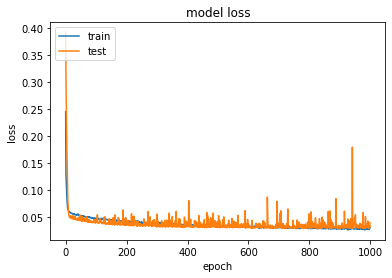

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

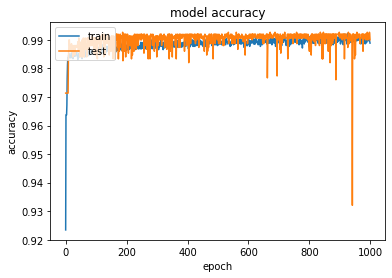

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
keras.backend.clear_session()